### Przydzielona karta graficzna:

In [0]:
!nvidia-smi

Thu Jun 20 12:48:22 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   78C    P0    34W /  70W |   9184MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

### Import bibliotek

In [0]:
import numpy as np
import matplotlib.pyplot as plt
!pip install imgaug
!pip install scikit-learn
from imgaug import augmenters as iaa
from imgaug import parameters as iap
import random
import pandas as pd

from sklearn.model_selection import train_test_split

%matplotlib inline

In [0]:
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D, Lambda

!pip install livelossplot
from livelossplot import PlotLossesKeras
from livelossplot.keras import PlotLossesCallback


### Wczytanie tensorów X i y

In [0]:
X = np.load('Xkw.npy')
y = np.load('ykw.npy')

In [0]:
print(X.shape, y.shape)

### Zdefiniowanie parametrów augmentacji

0.0


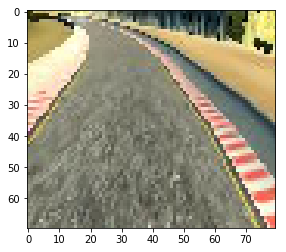

0.1


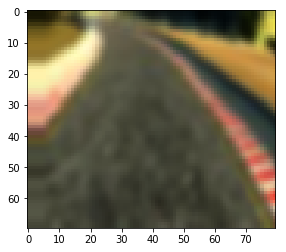

In [0]:
def augment(img, steering_angle):
  ##flip
  if random.random() > 0.5:
    img = img[:, ::-1, :]
    steering_angle = -steering_angle
  
  ##blur
  blurer = iaa.GaussianBlur(iap.Uniform(0.1, 2))
  img = blurer.augment_image(img)
  
  contrast = iaa.GammaContrast((0.5,2.0))
  img = contrast.augment_image(img)
  
  ##channel shuffle
  sh = iaa.ChannelShuffle(p=0.4)
  img = sh.augment_image(img)
  
  #snow = iaa.Snowflakes(density=(0.03,0.075))
  #img = snow.augment_image(img)
  
  ##fog
  ##fog = iaa.Fog()
  #img = fog.augment_image(img)
  
  #translate
  tx = random.randint(-20,20)
  translater = iaa.Affine(translate_px={"x":tx}, mode = "edge")
  steering_angle += tx*0.025
  
  img = translater.augment_image(img)
    
  return img, steering_angle
  
plt.imshow(X[0])
print(y[0])
plt.show();
  
img, angle = augment(X[0], y[0])
plt.imshow(img)
print(angle)
plt.show();

### Podział danych na zbiór treningowy i walidacyjny

In [0]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=10)

In [0]:

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

### Augmentacja danych

In [0]:
Xgen=[]
ygen=[]


for i in range(X_train.shape[0]):
  img,angle = augment(X[i],y[i])
  Xgen.append(img)
  ygen.append(angle)
  
  
Xgen = np.array(Xgen)
ygen = np.array(ygen)
print(Xgen.shape, ygen.shape)

(7593, 70, 80, 3) (7593,)


### Porównanie y przed i po augmentacji

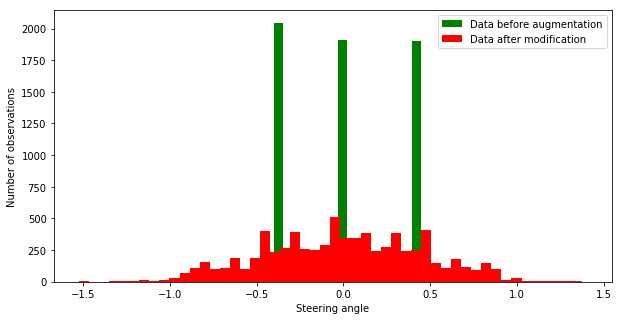

In [0]:
plt.figure(figsize=(10,5))
plt.hist(y_train, 50, facecolor='green');
plt.hist(ygen, 50, facecolor='red');
plt.xlabel('Steering angle');
plt.ylabel('Number of observations');
plt.legend(['Data before augmentation','Data after modification']);
plt.show()

### Budowa architektury CNN - wariant 5

In [0]:
# MODEL WŁASNY 06

def myModel(input_shape):
  model = Sequential([
      Lambda(lambda x: (x-128.0)/255.0, input_shape = input_shape, 
             name='normalize'),
          
  
      Conv2D(64,(3,3), activation = 'relu',input_shape = input_shape), 
      Conv2D(32,(3,3), activation = 'relu'),
      MaxPooling2D(pool_size=(2,2)),
      
      Conv2D(16,(3,3), activation = 'relu'),
      MaxPooling2D(pool_size=(2,2)),
      
      Conv2D(8,(3,3), activation = 'relu'),
      MaxPooling2D(pool_size=(2,2)),
      
      Dropout(rate=0.5),
      
      Flatten(),
      
      Dense(384, activation = 'relu'),
      Dropout(rate=0.3),
      Dense(384, activation = 'relu'),
      Dropout(rate=0.3),
      Dense(384, activation = 'relu'),
      Dropout(rate=0.3),
      Dense(16, activation = 'relu'),
      Dense(1)
  ])
  return model
model = myModel(X[0].shape)


### Kompilacja modelu

In [0]:
model.compile(optimizer='adam', 
              loss='mean_squared_error')
model.summary()

### Trenowanie modelu

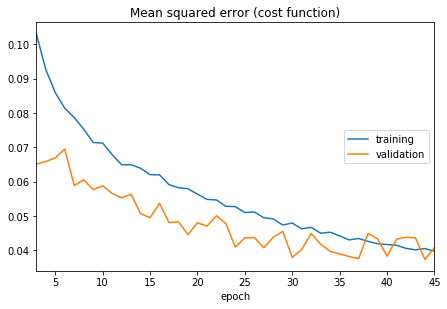

Mean squared error (cost function):
training   (min:    0.040, max:    0.177, cur:    0.040)
validation (min:    0.037, max:    0.082, cur:    0.041)


In [0]:
batch_size = 512
epochs = 45
history = model.fit(Xgen, ygen,
         batch_size=batch_size,
         epochs=epochs,
         validation_data=(X_val, y_val),
         callbacks=[PlotLossesCallback()],
         )


### Predykcja y i porównanie y z y_pred

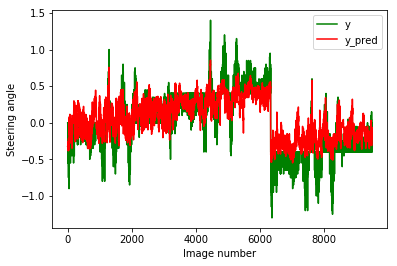

In [0]:
y_pred = model.predict(X)

plt.figure()
plt.plot(y,'g', y_pred,'r')
plt.xlabel('Image number');
plt.ylabel('Steering angle');
plt.legend(['y','y_pred']);

plt.show();

### Zapis modelu

In [0]:
model.save('cnn_model_wlasny_05_b512_e45_relu_kw.h5')